In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from attention_modules import *

In [59]:
class Block_conv(nn.Module):
    def __init__(self, in_channels, kernel_size=5, padding=2, stride=1):
        super().__init__()
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.conv_e = nn.Conv2d(in_channels, in_channels*2, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=False,groups=in_channels)
        self.conv_k = nn.Conv2d(in_channels*2, in_channels*2, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=False,groups=in_channels*2)
        self.conv_r = nn.Conv2d(in_channels*2, in_channels, kernel_size=self.kernel_size, stride=1, padding=self.padding, bias=False,groups=in_channels)
        self.bn = nn.BatchNorm2d(in_channels)
        self.activation = nn.GELU()
        self.attention = CBAMBlock(in_channels*2)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = self.bn(x)
        x = self.dropout(self.activation(self.conv_e(x)))
        x = self.dropout(self.activation(self.conv_k(x)))
        x = self.attention(x)
        x = self.dropout(self.activation(self.conv_r(x)))
        return x
class Block_MLP(nn.Module):
    def __init__(self, in_channels, block_row_input, block_row_output):
        super().__init__()
        self.in_channels = in_channels
        self.block_row_input = block_row_input
        self.block_row_output = block_row_output
        #multihead attention
        self.attention = nn.MultiheadAttention(embed_dim=block_row_output*block_row_output, num_heads=8, dropout=0.1)
        #mlp layers
        self.mlp = nn.Sequential(
            nn.Linear(block_row_input*block_row_input, block_row_input*block_row_input*2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(block_row_input*block_row_input*2, block_row_input*block_row_input*2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(block_row_input*block_row_input*2, block_row_output*block_row_output),
            nn.GELU(),
            nn.Dropout(0.1)
        )
    def forward(self, x):
        x = x.reshape(x.shape[0],self.block_row_input*self.block_row_input)
        x = self.mlp(x)
        x = self.attention(x,x,x)[0]
        x = x.reshape(x.shape[0],self.block_row_output,self.block_row_output)
    
        return x
class Trynet(nn.Module):
    def __init__(self, block_size=16,in_channels=3):
        super().__init__()
        self.block_size = block_size
        self.in_channels = in_channels
        self.number_of_res_blocks = [2,2,2,2]
        #bring channels to 64
        self.conv_1 = nn.Conv2d(in_channels, 64, kernel_size=1, stride=1, padding=1, bias=False)
        self.block_conv_1 = nn.Sequential(*[Block_conv(64,kernel_size=3,padding=1) for i in range(self.number_of_res_blocks[0])])
        #self.block_mlp_1 = nn.ModuleList([Block_MLP(64*256,block_row_input=16,block_row_output=8) for i in range(self.in_channels*256)])
        


    def forward(self, x):
        x = self.conv_1(x)
        #x = x.reshape(x.shape[0],x.shape[1]*256, self.block_size,self.block_size)
        x = self.block_conv_1(x)
        #x = torch.stack([self.block_mlp_1[i](x[:,i,:,:]) for i in range(x.shape[1])],dim=1)
        #merge blocks
        #x = x.reshape(x.shape[0],3,128,128)
        return x

(256, 256)
torch.Size([1, 3, 256, 256])
torch.Size([1, 64, 258, 258])
0.021062


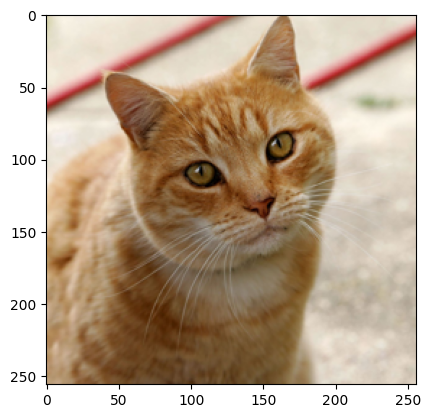

In [60]:
 #read the image cat.png and convert it to a tensor
img = Image.open('cat.jpg')
img = img.resize((256, 256))
plt.imshow(img)
print(img.size)
img = np.array(img)
img = img.transpose((2, 0, 1))
img = torch.from_numpy(img).float()

img = img.unsqueeze(0)
#show the image
print(img.shape)

model = Trynet()
x = torch.randn(1, 3, 256, 256)
x = model(img)
print(x.shape)
#show the number of parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000) 

